<a href="https://colab.research.google.com/github/peisuke/generative_ai_notebooks/blob/main/Vision/14_DreamTalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b dev https://github.com/camenduru/dreamtalk
%cd /content/dreamtalk

Cloning into 'dreamtalk'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 164 (delta 13), reused 150 (delta 7), pack-reused 0
Receiving objects: 100% (164/164), 28.14 MiB | 20.84 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/dreamtalk


In [2]:
!wget https://huggingface.co/camenduru/dreamtalk/resolve/main/damo/dreamtalk/checkpoints/denoising_network.pth -O /content/dreamtalk/checkpoints/denoising_network.pth
!wget https://huggingface.co/camenduru/dreamtalk/resolve/main/damo/dreamtalk/checkpoints/renderer.pt -O /content/dreamtalk/checkpoints/renderer.pt
!pip install -q yacs av

--2024-01-08 10:29:17--  https://huggingface.co/camenduru/dreamtalk/resolve/main/damo/dreamtalk/checkpoints/denoising_network.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/12/d0/12d04da432c426f121297a0e52a95d635674fc5b6a26775a732b59caa5c94a4e/93864d1316f60e75b40bd820707bb2464f790b1636ae2b9275ee500d41c4e3ae?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27denoising_network.pth%3B+filename%3D%22denoising_network.pth%22%3B&Expires=1704968957&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNDk2ODk1N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzEyL2QwLzEyZDA0ZGE0MzJjNDI2ZjEyMTI5N2EwZTUyYTk1ZDYzNTY3NGZjNWI2YTI2Nzc1YTczMmI1OWNhYTVjOTRhNGUvOTM4NjRkMTMxNmY2MGU3NWI0MGJkODIwNzA

In [3]:
import os
import numpy as np
import torch
import torchaudio
import shutil
from PIL import Image
from core.utils import crop_src_image
from configs.default import get_cfg_defaults

from inference_for_demo_video import (
    get_diff_net,
    inference_one_video,
    get_netG,
    render_video,
)

from transformers import Wav2Vec2Processor
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2Model

In [4]:
wav_path = "data/audio/acknowledgement_english.m4a"
image_path = "data/src_img/uncropped/male_face.png"

In [5]:
output_name = "output"

style_clip_path = "data/style_clip/3DMM/M030_front_neutral_level1_001.mat"
pose_path = "data/pose/RichardShelby_front_neutral_level1_001.mat"
max_gen_len = 1000
cf_guidance_scale = 1.0

tmp_dir = f"tmp/{output_name}"
os.makedirs(tmp_dir, exist_ok=True)

# generate face motion
face_motion_path = os.path.join(tmp_dir, f"{output_name}_facemotion.npy")

# render video
output_video_path = f"output_video/{output_name}.mp4"

In [6]:
cfg = get_cfg_defaults()
cfg.CF_GUIDANCE.SCALE = cf_guidance_scale
cfg.freeze()

In [7]:
# Convert audio data to 16K format
wav_16k_path = os.path.join(tmp_dir, f"{output_name}_16K.wav")
!ffmpeg -y -i {wav_path} -async 1 -ac 1 -vn -acodec pcm_s16le -ar 16000 {wav_16k_path}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [8]:
# get wav2vec feat from audio
wav2vec_processor = Wav2Vec2Processor.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-english"
)

wav2vec_model = (
    Wav2Vec2Model.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
    .eval()
    .cuda()
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
speech_array, sampling_rate = torchaudio.load(wav_16k_path)
audio_data = speech_array.squeeze().numpy()

inputs = wav2vec_processor(
    audio_data, sampling_rate=16_000, return_tensors="pt", padding=True
)

with torch.no_grad():
    audio_embedding = wav2vec_model(inputs.input_values.cuda(), return_dict=False)[0]

audio_feat_path = os.path.join(tmp_dir, f"{output_name}_wav2vec.npy")
np.save(audio_feat_path, audio_embedding[0].cpu().numpy())

In [10]:
# get src image
src_img_path = os.path.join(tmp_dir, "src_img.png")
crop_src_image(image_path, src_img_path, 0.4)

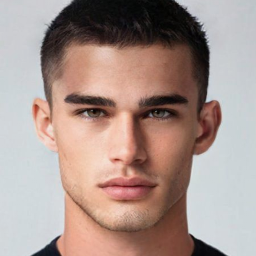

In [11]:
Image.open(src_img_path)

In [12]:
with torch.no_grad():
    # get diff model and load checkpoint
    diff_net = get_diff_net(cfg).cuda()

    inference_one_video(
        cfg,
        audio_feat_path,
        style_clip_path,
        pose_path,
        face_motion_path,
        diff_net,
        max_audio_len=max_gen_len,
    )

    # get renderer
    renderer = get_netG("checkpoints/renderer.pt")

    render_video(
        renderer,
        src_img_path,
        face_motion_path,
        wav_16k_path,
        output_video_path,
        fps=25,
        no_move=False,
    )

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [14]:
# mp4動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open(f'./output_video/{output_name}.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="300px" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")